In [1]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)

In [6]:
BIN_TRAIN_DATA_PATH = "./cicddos_data/out/bin-train.csv"
BIN_TEST_DATA_PATH = "./cicddos_data/out/bin-test.csv"

In [7]:
bin_train_df = pd.read_csv(BIN_TRAIN_DATA_PATH, low_memory=False)
bin_test_df = pd.read_csv(BIN_TEST_DATA_PATH, low_memory=False)

In [8]:
bin_train_df['Label'].value_counts()

DrDoS_SSDP       199955
Syn              199948
DrDoS_SNMP       199944
DrDoS_NetBIOS    199904
DrDoS_MSSQL      199897
DrDoS_DNS        199868
DrDoS_LDAP       199855
DrDoS_UDP        199822
TFTP             199730
UDP-lag          197778
DrDoS_NTP        197597
BENIGN            51171
WebDDoS             231
Name: Label, dtype: int64

In [9]:
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        columns_to_be_removed = ['Flow ID', 'Source IP', 
                                 'Source Port', 'Destination IP', 
                                 'Destination Port', 'Timestamp', 
                                 'SimillarHTTP', 'Flow Bytes/s', 'Flow Packets/s', 'Total Backward Packets',
                                 'Init_Win_bytes_backward', 'Down/Up Ratio', 'Active Max', 'Active Min',
                                 'Idle Max', 'Idle Min', 'Packet Length Variance', 'Min Packet Length', 'Max Packet Length',
                                 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Max', 'Fwd Packet Length Max', 
                                 'Fwd Packet Length Min']
        for col_name in X.columns:
            if "Bwd " in col_name:
                columns_to_be_removed.append(col_name)
        
        return X.drop(columns_to_be_removed, axis=1, inplace=False)

class SeparateLabelsFromX(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        return X.drop(["Label", "attack_type"], axis=1, inplace=False)

us_pipeline = Pipeline([
    ("label_seperator", SeparateLabelsFromX()),
    ("feature_filter", FilterFeatures()),
    ("std_scaler", StandardScaler()),
    ("normalizer", Normalizer()),
    ("imputer", SimpleImputer(strategy="median"))
])

In [10]:
def get_req_cols():
    with open("./pkls/req_cols.pkl", "rb") as f:
        return pkl.load(f)

In [12]:
columns_to_be_removed = ['Flow ID', 'Source IP', 
                                 'Source Port', 'Destination IP', 
                                 'Destination Port', 'Timestamp', 
                                 'SimillarHTTP', 'Flow Bytes/s', 'Flow Packets/s', 'Total Backward Packets',
                                 'Init_Win_bytes_backward', 'Down/Up Ratio', 'Active Max', 'Active Min',
                                 'Idle Max', 'Idle Min', 'Packet Length Variance', 'Min Packet Length', 'Max Packet Length',
                                 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Max', 'Fwd Packet Length Max', 
                                 'Fwd Packet Length Min']

In [18]:
X_arr = us_pipeline.fit_transform(bin_train_df)
req_cols = get_req_cols().tolist()
# req_cols.remove("Label")
# req_cols.remove("attack_type")
# for col_name in columns_to_be_removed:
#     if col_name in req_cols:
#         req_cols.remove(col_name)
X_train = pd.DataFrame(X_arr, columns=req_cols)
del X_arr

In [17]:
len(get_req_cols().tolist())

42

In [19]:
X_arr = us_pipeline.fit_transform(bin_test_df)
req_cols = get_req_cols()
X_test = pd.DataFrame(X_arr, columns=req_cols)
del X_arr

In [20]:
Y_train = bin_train_df['Label'] != 'BENIGN'

In [21]:
Y_test = bin_test_df['Label'] != 'BENIGN'

## PCA

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Visualizing DDoS attacks through PCA')

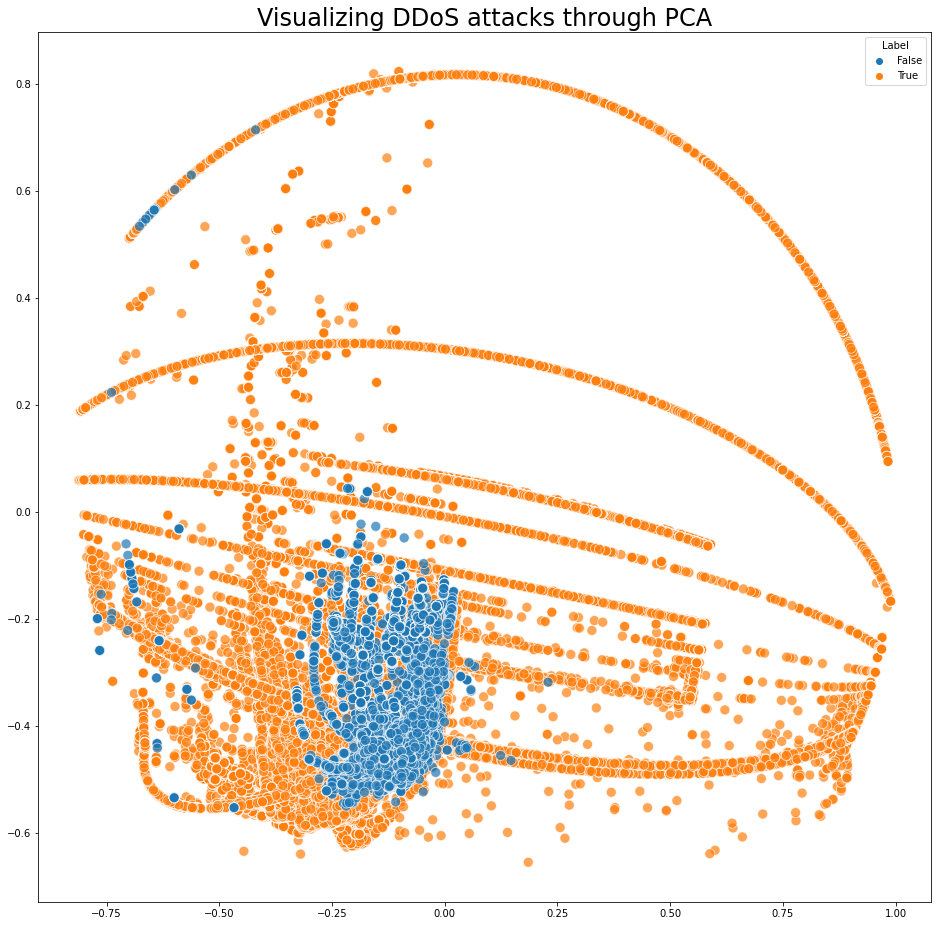

In [29]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(principalComponents[:, 0], principalComponents[:, 1], s= 100, hue=Y_train, cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through PCA', fontsize=24)

## TSNE

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Visualizing DDoS attacks through t-SNE')

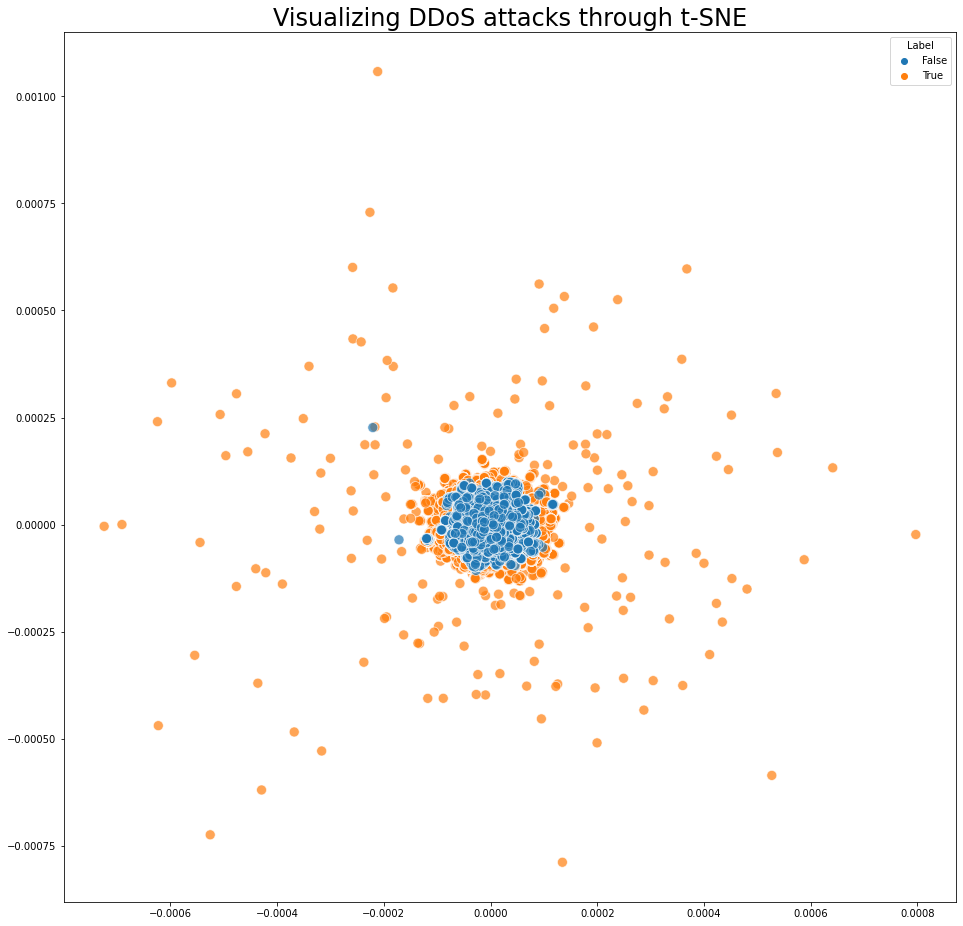

In [33]:
tsne_ = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=600).fit_transform(principalComponents)
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(tsne_[:, 0], tsne_[:, 1], s= 100, hue=Y_train, cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through t-SNE', fontsize=24)

In [35]:
with open("./pkls/tsne.pkl", "wb") as f:
    pkl.dump(tsne_, f)

In [36]:
del tsne_

## SVM

In [22]:
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [23]:
svm_clf = Pipeline([
    ('linear_svc', LinearSVC(C=10, loss="hinge"))
])

In [24]:
svm_clf.fit(X_train, Y_train)

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('linear_svc', LinearSVC(C=10, loss='hinge'))])

In [25]:
predicted_vals = svm_clf.predict(X_test)

In [57]:
Y_test.value_counts()

True     21949
False     5692
Name: Label, dtype: int64

In [26]:
predicted_vals[:5]

array([ True,  True,  True,  True,  True])

In [29]:
mean_squared_error(Y_test_num, predicted_vals)

0.08024311710864296

In [27]:
Y_test_num = [int(x) for x in Y_test.values]

In [28]:
predicted_vals = [int(x) for x in predicted_vals]

In [30]:
accuracies = cross_val_score(svm_clf, X_test, Y_test, cv=3, scoring='accuracy')
print("Model Accuracy:")
for i in accuracies:
    print(i)

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Accuracy:
0.9973952680703277
0.9982635120468851
0.9769890372300011


/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [74]:
X_train.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Min',
       'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Fwd Packets/s',
       'Packet Length Mean', 'Packet Length Std', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Fwd Header Length.1',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Init_Win_bytes_forward',
       'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
       'Idle Mean', 'Idle Std', 'Inbound'],
      dtype='object')

In [35]:
with open('./pkls/models/svm.pkl', 'wb') as f:
    pkl.dump(svm_clf, f)

In [37]:
Y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2245700 entries, 0 to 2245699
Series name: Label
Non-Null Count    Dtype
--------------    -----
2245700 non-null  bool 
dtypes: bool(1)
memory usage: 2.1 MB


In [38]:
X_train.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Fwd Packets/s,Packet Length Mean,Packet Length Std,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Average Packet Size,Avg Fwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Init_Win_bytes_forward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Idle Mean,Idle Std,Inbound
0,0.241523,-0.074040,-0.009137,-0.074265,-0.245387,0.331365,-0.084080,-0.083886,-0.073731,-0.085105,-0.083539,-0.003927,-0.028260,0.0,0.026028,-0.608713,-0.249612,0.179822,0.0,-0.005559,-0.028260,0.0,-0.233013,-0.051730,-0.035660,0.0,-0.279012,-0.245387,0.026028,0.0,0.0,0.0,-0.009137,-0.074265,-0.165137,-0.074716,0.099983,-0.013455,-0.013193,-0.072969,-0.054174,0.072556
1,0.241565,-0.073918,-0.009139,-0.074278,-0.245429,0.331422,-0.083655,-0.083411,-0.073610,-0.084710,-0.083084,-0.003911,-0.028265,0.0,0.026033,-0.608817,-0.249655,0.179853,0.0,-0.005560,-0.028265,0.0,-0.233053,-0.051739,-0.035667,0.0,-0.279060,-0.245429,0.026033,0.0,0.0,0.0,-0.009139,-0.074278,-0.165165,-0.074728,0.100000,-0.013457,-0.013196,-0.072981,-0.054183,0.072568
2,0.430790,-0.141524,-0.022680,-0.154197,-0.180749,-0.214140,-0.180959,-0.184190,-0.140979,-0.180670,-0.182127,-0.006946,-0.050406,0.0,0.046425,-0.079747,-0.181510,-0.155550,0.0,-0.009915,-0.050406,0.0,-0.415611,-0.092268,-0.063605,0.0,-0.141478,-0.180749,0.046425,0.0,0.0,0.0,-0.022680,-0.154197,-0.294545,-0.202962,0.178334,-0.023999,-0.023532,-0.130150,-0.096627,0.129414
3,0.276223,-0.090742,-0.014543,-0.105804,-0.224267,-0.137307,-0.116006,-0.118103,-0.090393,-0.115822,-0.116780,-0.003624,-0.032320,0.0,0.029768,-0.668742,-0.224803,-0.099738,0.0,-0.006357,-0.032320,0.0,-0.266490,-0.059162,-0.040784,0.0,-0.197366,-0.224267,0.029768,0.0,0.0,0.0,-0.014543,-0.105804,-0.188862,-0.130139,0.114348,-0.015388,-0.015089,-0.083452,-0.061957,0.082980
4,0.084595,-0.027791,-0.004454,-0.032789,-0.074718,-0.042051,-0.035536,-0.036170,-0.027684,-0.035479,-0.035765,-0.001375,-0.009898,0.0,-0.141613,-0.213214,-0.074885,-0.030546,0.0,-0.001947,-0.009898,0.0,-0.081615,-0.018119,-0.012490,0.0,-0.066384,-0.074718,-0.141613,0.0,0.0,0.0,-0.004454,-0.032789,-0.057841,-0.039856,-0.927670,-0.004713,-0.004621,-0.025558,-0.018975,0.025413


In [39]:
X_train.to_csv("/home/ubuntu/projects/ddos/cicddos_data/core/train/X.csv", index=False, mode="w")

In [40]:
Y_trainain.head()

0    True
1    True
2    True
3    True
4    True
Name: Label, dtype: bool

In [41]:
Y_train.to_csv("/home/ubuntu/projects/ddos/cicddos_data/core/train/Y.csv", index=False, mode="w")

In [42]:
X_test.to_csv("/home/ubuntu/projects/ddos/cicddos_data/core/test/X.csv", index=False, mode="w")

In [43]:
Y_test.to_csv("/home/ubuntu/projects/ddos/cicddos_data/core/test/Y.csv", index=False, mode="w")